In [1]:
#
# Most of code taken from -- https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/
#
# example of training an conditional gan on the fashion mnist dataset
import os
os.environ["CUDA_VISIBLE_DEVICES"] = str(0)
import sys
# sys.path.append('..')
# from utils import foldername2class

from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint

# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.models import load_model
from matplotlib import pyplot


import tensorflow as tf


from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras import initializers

from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
from sklearn.utils import shuffle

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
foldername2class = {
	'0.0':  0,
	'0.05': 1,
	'0.1':  2,
	'0.15': 3,
	'0.2':  4,
	'0.25': 5,
	'0.3':  6,
	'0.35': 7,
	'0.4':  8,
	'0.45': 9,
	'0.5':  10,
	'0.55': 11,
	'0.6':  12,
	'0.65': 13,
	'0.7':  14,
	'0.75': 15,
	'0.8':  16,
	'0.85': 17,
	'0.9':  18,
	'0.95': 19,
	'1.0':  20,
}

In [4]:
H, W, C = 336, 336, 3
batch_size = 10
PATH_DATA = '../../expand_double_modes'
SAVE_RESULT = 'exp_result'

train_images_path = []

iterator = tqdm(glob.glob(PATH_DATA + "/*"))
for single_folder in iterator:
    img_folder = shuffle(glob.glob(single_folder + '/*'))
    for indx, single_img_path in enumerate(img_folder):
        train_images_path.append(single_img_path)
iterator.close()

train_images_path = shuffle(train_images_path)

100%|██████████| 21/21 [00:00<00:00, 160.93it/s]


In [5]:
def preprocess_images(images):
  images = (images - 127.5) / 127.5
  return images.astype('float32')

def generator_img(path_list: list):
    counter = 0
    max_counter = len(path_list)
    while True:
        single_path = path_list[counter]
        label_s = foldername2class[single_path.split('/')[-2]]
        image_s = preprocess_images(np.asarray(io.imread(single_path), dtype=np.float32))
        yield image_s, label_s
        # yield np.ones((336, 336, 3))
        counter += 1

        if counter == max_counter:
            counter = 0
            path_list = shuffle(path_list)

def train_gen():
    return generator_img(train_images_path)

In [6]:
dataset = (
    tf.data.Dataset.from_generator(
        train_gen, 
        output_signature=(
            tf.TensorSpec(shape=(H, W, C), dtype=np.float32),
            tf.TensorSpec(shape=(), dtype=np.int32),
        )
    )
    .shuffle(batch_size * 10).batch(batch_size)
)


In [7]:
train_size = len(train_images_path)

print(f'train: {train_size}')

train: 37800


In [8]:
def init_weights():
    return initializers.RandomNormal(stddev=0.02)

def init_weights():
    return None

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=21):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

# create and save a plot of generated images
def save_figure(examples, n, prefix=0):
    # plot images
    fig = pyplot.figure(figsize=(12,12))
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i])
    #pyplot.show()
    fig.savefig(f'{prefix}_image.png')
    plt.close('all')

In [9]:
# define the standalone discriminator model
def define_discriminator(in_shape, n_classes=21):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 128)(in_label)
    # scale up to image dimensions with linear activation
    n_nodes = in_shape[0] * in_shape[1] * in_shape[2]
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((in_shape[0], in_shape[1], in_shape[2]))(li)
    # image input
    in_image = Input(shape=in_shape)
    # concat label as a channel
    merge = Concatenate()([in_image, li])                         # 336
    # downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init_weights())(merge) # 168
    #fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init_weights())(fe)    # 84  
    #fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init_weights())(fe)    # 42 
    #fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init_weights())(fe)    # 21 
    #fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    
    fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init_weights())(fe)                   # 21 
    #fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    out_layer = Conv2D(1, (1,1), padding='same', activation='sigmoid', kernel_initializer=init_weights())(fe)
    # flatten feature maps
    #fe = Flatten()(fe)
    #fe = Dropout(0.25)(fe)
    #out_layer = Dense(1, activation='sigmoid')(fe)
    # define model
    model = Model([in_image, in_label], out_layer)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5) # Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# define the standalone generator model
def define_generator(latent_dim, n_classes=21, h_low=21, w_low=21):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 128)(in_label)
    # linear multiplication
    n_nodes = h_low * w_low
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((h_low, w_low, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for h_low x w_low image
    n_nodes = 64 * h_low * w_low
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((h_low, w_low, 64))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 42
    gen = Conv2DTranspose(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init_weights())(merge)  
    gen = BatchNormalization(trainable=False)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # upsample to 84
    gen = Conv2DTranspose(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init_weights())(gen)
    gen = BatchNormalization(trainable=False)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # upsample to 168
    gen = Conv2DTranspose(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init_weights())(gen)
    gen = BatchNormalization(trainable=False)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # upsample to 336
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init_weights())(gen)
    gen = BatchNormalization(trainable=False)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # output
    out_layer = Conv2D(C, (4,4), activation='tanh', padding='same', kernel_initializer=init_weights())(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input
    # get image output from the generator model
    gen_output = g_model.output
    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# load fashion mnist images
def load_real_samples():
    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return [X, trainy]

# # select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    X, labels = list(dataset.take(1))[0]
    # choose random instances
    #ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    #X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 21, 21, 1)) * 0.9
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=21):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 21, 21, 1))
    return [images, labels_input], y

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1, n_batch=128, dataset_size=30000):
    bat_per_epo = int(dataset_size / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            # generate 'fake' examples
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            # prepare points in latent space as input for the generator
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 21, 21, 1)) # * 0.9 do not use label smoothing
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
            
            if j % 50 == 0:
                g_model.save(os.path.join(SAVE_RESULT, 'cgan_generator.h5'))
                # load model
                model = load_model(os.path.join(SAVE_RESULT, 'cgan_generator.h5'))
                # generate images
                latent_points, labels = generate_latent_points(latent_dim, 100)
                # specify labels
                labels = asarray([x for _ in range(10) for x in range(10)])
                # generate images
                X  = model.predict([latent_points, labels])
                # scale from [-1,1] to [0,1]
                X = (X + 1) / 2.0
                # plot the result
                save_figure(X, 10, prefix=os.path.join(SAVE_RESULT, f'e_{i}_be_{j}'))
    # save the generator model
    g_model.save('cgan_generator.h5')

In [10]:
# size of the latent space
latent_dim = 100

In [11]:
# create the discriminator
d_model = define_discriminator((H, W, C))

In [12]:
# create the generator
g_model = define_generator(latent_dim, n_classes=21)

In [13]:
# create the gan
gan_model = define_gan(g_model, d_model)

In [14]:
# load image data
#dataset = load_real_samples()
#dataset = (train_images, train_labels)

In [15]:
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=batch_size * 2)

>1, 1/1500, d1=0.698, d2=0.695 g=0.692
>1, 2/1500, d1=0.597, d2=0.695 g=0.693
>1, 3/1500, d1=0.498, d2=0.695 g=0.693
>1, 4/1500, d1=0.388, d2=0.697 g=0.692
>1, 5/1500, d1=0.337, d2=0.701 g=0.691
>1, 6/1500, d1=0.338, d2=0.708 g=0.685
>1, 7/1500, d1=0.337, d2=0.732 g=0.666
>1, 8/1500, d1=0.338, d2=0.792 g=0.633
>1, 9/1500, d1=0.350, d2=0.898 g=0.599
>1, 10/1500, d1=0.387, d2=0.963 g=0.596
>1, 11/1500, d1=0.450, d2=0.945 g=0.632
>1, 12/1500, d1=0.532, d2=0.860 g=0.674
>1, 13/1500, d1=0.598, d2=0.772 g=0.694
>1, 14/1500, d1=0.614, d2=0.717 g=0.702
>1, 15/1500, d1=0.612, d2=0.701 g=0.710
>1, 16/1500, d1=0.607, d2=0.686 g=0.715
>1, 17/1500, d1=0.607, d2=0.679 g=0.720
>1, 18/1500, d1=0.598, d2=0.676 g=0.725
>1, 19/1500, d1=0.596, d2=0.669 g=0.733
>1, 20/1500, d1=0.611, d2=0.667 g=0.736
>1, 21/1500, d1=0.599, d2=0.662 g=0.745
>1, 22/1500, d1=0.599, d2=0.659 g=0.769
>1, 23/1500, d1=0.628, d2=0.640 g=0.785
>1, 24/1500, d1=0.615, d2=0.638 g=0.796
>1, 25/1500, d1=0.666, d2=0.636 g=0.782
>1, 26/15

>1, 192/1500, d1=0.650, d2=0.367 g=2.260
>1, 193/1500, d1=0.788, d2=0.275 g=1.613
>1, 194/1500, d1=0.719, d2=0.413 g=2.193
>1, 195/1500, d1=0.609, d2=0.402 g=2.424
>1, 196/1500, d1=0.821, d2=0.413 g=2.202
>1, 197/1500, d1=0.592, d2=0.421 g=2.019
>1, 198/1500, d1=0.723, d2=0.387 g=1.970
>1, 199/1500, d1=0.581, d2=0.325 g=2.156
>1, 200/1500, d1=0.703, d2=0.361 g=2.104
>1, 201/1500, d1=0.655, d2=0.395 g=1.732
>1, 202/1500, d1=0.688, d2=0.470 g=1.869
>1, 203/1500, d1=0.678, d2=0.569 g=1.542
>1, 204/1500, d1=0.596, d2=0.459 g=2.428
>1, 205/1500, d1=0.852, d2=1.139 g=1.569
>1, 206/1500, d1=0.769, d2=0.556 g=1.558
>1, 207/1500, d1=0.813, d2=0.473 g=1.562
>1, 208/1500, d1=0.666, d2=0.602 g=1.532
>1, 209/1500, d1=0.741, d2=0.736 g=1.806
>1, 210/1500, d1=1.060, d2=0.567 g=1.075
>1, 211/1500, d1=0.796, d2=0.698 g=0.919
>1, 212/1500, d1=0.671, d2=0.742 g=1.268
>1, 213/1500, d1=0.778, d2=0.666 g=1.242
>1, 214/1500, d1=0.781, d2=0.607 g=1.264
>1, 215/1500, d1=0.776, d2=0.554 g=1.100
>1, 216/1500, d1

>1, 380/1500, d1=0.788, d2=0.578 g=0.841
>1, 381/1500, d1=0.707, d2=0.558 g=0.820
>1, 382/1500, d1=0.768, d2=0.627 g=0.889
>1, 383/1500, d1=0.753, d2=0.570 g=0.879
>1, 384/1500, d1=0.737, d2=0.621 g=0.863
>1, 385/1500, d1=0.740, d2=0.592 g=0.907
>1, 386/1500, d1=0.718, d2=0.645 g=0.883
>1, 387/1500, d1=0.714, d2=0.605 g=0.860
>1, 388/1500, d1=0.734, d2=0.647 g=0.777
>1, 389/1500, d1=0.753, d2=0.591 g=0.804
>1, 390/1500, d1=0.736, d2=0.654 g=0.894
>1, 391/1500, d1=0.728, d2=0.567 g=0.820
>1, 392/1500, d1=0.751, d2=0.634 g=0.793
>1, 393/1500, d1=0.716, d2=0.645 g=0.875
>1, 394/1500, d1=0.756, d2=0.621 g=0.839
>1, 395/1500, d1=0.745, d2=0.630 g=0.880
>1, 396/1500, d1=0.726, d2=0.602 g=1.014
>1, 397/1500, d1=0.725, d2=0.572 g=0.835
>1, 398/1500, d1=0.767, d2=0.527 g=0.901
>1, 399/1500, d1=0.735, d2=0.655 g=0.912
>1, 400/1500, d1=0.734, d2=0.510 g=1.089
>1, 401/1500, d1=0.725, d2=0.561 g=1.583
>1, 402/1500, d1=0.767, d2=0.642 g=0.880
>1, 403/1500, d1=0.754, d2=0.569 g=0.818
>1, 404/1500, d1

>1, 568/1500, d1=0.768, d2=0.558 g=1.018
>1, 569/1500, d1=0.783, d2=0.546 g=0.969
>1, 570/1500, d1=0.763, d2=0.615 g=1.401
>1, 571/1500, d1=0.751, d2=0.578 g=1.114
>1, 572/1500, d1=0.739, d2=0.631 g=0.856
>1, 573/1500, d1=0.741, d2=0.602 g=1.284
>1, 574/1500, d1=0.760, d2=0.527 g=0.842
>1, 575/1500, d1=0.765, d2=0.484 g=0.888
>1, 576/1500, d1=0.766, d2=0.591 g=1.059
>1, 577/1500, d1=0.756, d2=0.537 g=0.933
>1, 578/1500, d1=0.761, d2=0.581 g=1.087
>1, 579/1500, d1=0.772, d2=0.625 g=0.854
>1, 580/1500, d1=0.732, d2=0.584 g=0.897
>1, 581/1500, d1=0.761, d2=0.572 g=0.899
>1, 582/1500, d1=0.759, d2=0.606 g=0.893
>1, 583/1500, d1=0.771, d2=0.525 g=0.869
>1, 584/1500, d1=0.798, d2=0.554 g=1.117
>1, 585/1500, d1=0.743, d2=0.498 g=0.905
>1, 586/1500, d1=0.775, d2=0.598 g=1.046
>1, 587/1500, d1=0.727, d2=0.526 g=0.906
>1, 588/1500, d1=0.751, d2=0.592 g=0.916
>1, 589/1500, d1=0.767, d2=0.535 g=1.235
>1, 590/1500, d1=0.741, d2=0.554 g=0.822
>1, 591/1500, d1=0.755, d2=0.578 g=1.072
>1, 592/1500, d1

>1, 756/1500, d1=0.729, d2=0.457 g=1.442
>1, 757/1500, d1=0.861, d2=0.555 g=1.067
>1, 758/1500, d1=0.774, d2=0.522 g=1.078
>1, 759/1500, d1=0.774, d2=0.583 g=0.909
>1, 760/1500, d1=0.711, d2=0.603 g=1.189
>1, 761/1500, d1=0.733, d2=0.634 g=1.245
>1, 762/1500, d1=0.699, d2=0.666 g=1.008
>1, 763/1500, d1=0.749, d2=0.659 g=1.125
>1, 764/1500, d1=0.784, d2=0.587 g=1.185
>1, 765/1500, d1=0.796, d2=0.433 g=1.016
>1, 766/1500, d1=0.759, d2=0.576 g=0.846
>1, 767/1500, d1=0.755, d2=0.537 g=0.980
>1, 768/1500, d1=0.720, d2=0.544 g=1.142
>1, 769/1500, d1=0.717, d2=0.565 g=0.874
>1, 770/1500, d1=0.775, d2=0.556 g=1.085
>1, 771/1500, d1=0.761, d2=0.555 g=1.063
>1, 772/1500, d1=0.726, d2=0.589 g=1.137
>1, 773/1500, d1=0.760, d2=0.557 g=1.258
>1, 774/1500, d1=0.711, d2=0.480 g=1.300
>1, 775/1500, d1=0.803, d2=0.582 g=0.855
>1, 776/1500, d1=0.736, d2=0.629 g=1.148
>1, 777/1500, d1=0.730, d2=0.648 g=1.019
>1, 778/1500, d1=0.782, d2=0.617 g=1.124
>1, 779/1500, d1=0.745, d2=0.557 g=1.173
>1, 780/1500, d1

>1, 947/1500, d1=0.742, d2=0.496 g=1.007
>1, 948/1500, d1=0.742, d2=0.532 g=1.015
>1, 949/1500, d1=0.766, d2=0.561 g=0.971
>1, 950/1500, d1=0.708, d2=0.547 g=0.878
>1, 951/1500, d1=0.731, d2=0.608 g=0.972
>1, 952/1500, d1=0.720, d2=0.642 g=1.081
>1, 953/1500, d1=0.751, d2=0.560 g=0.981
>1, 954/1500, d1=0.732, d2=0.462 g=1.190
>1, 955/1500, d1=0.765, d2=0.592 g=0.956
>1, 956/1500, d1=0.747, d2=0.557 g=1.351
>1, 957/1500, d1=0.711, d2=0.559 g=0.868
>1, 958/1500, d1=0.751, d2=0.578 g=0.995
>1, 959/1500, d1=0.724, d2=0.633 g=1.031
>1, 960/1500, d1=0.751, d2=0.574 g=0.878
>1, 961/1500, d1=0.707, d2=0.586 g=1.130
>1, 962/1500, d1=0.776, d2=0.477 g=1.203
>1, 963/1500, d1=0.740, d2=0.570 g=1.216
>1, 964/1500, d1=0.715, d2=0.482 g=0.902
>1, 965/1500, d1=0.778, d2=0.516 g=1.155
>1, 966/1500, d1=0.757, d2=0.632 g=0.875
>1, 967/1500, d1=0.742, d2=0.600 g=1.194
>1, 968/1500, d1=0.733, d2=0.614 g=1.237
>1, 969/1500, d1=0.723, d2=0.569 g=1.260
>1, 970/1500, d1=0.726, d2=0.545 g=1.141
>1, 971/1500, d1

>1, 1132/1500, d1=0.698, d2=0.523 g=1.147
>1, 1133/1500, d1=1.083, d2=0.552 g=1.005
>1, 1134/1500, d1=0.791, d2=0.604 g=0.884
>1, 1135/1500, d1=0.709, d2=0.564 g=0.879
>1, 1136/1500, d1=0.770, d2=0.556 g=0.892
>1, 1137/1500, d1=0.697, d2=0.606 g=0.879
>1, 1138/1500, d1=0.690, d2=0.575 g=1.203
>1, 1139/1500, d1=0.846, d2=0.677 g=1.013
>1, 1140/1500, d1=0.733, d2=0.612 g=0.967
>1, 1141/1500, d1=0.686, d2=0.565 g=1.130
>1, 1142/1500, d1=0.765, d2=0.547 g=0.935
>1, 1143/1500, d1=0.740, d2=0.491 g=1.226
>1, 1144/1500, d1=0.754, d2=0.566 g=1.139
>1, 1145/1500, d1=0.705, d2=0.498 g=1.403
>1, 1146/1500, d1=0.833, d2=0.542 g=0.863
>1, 1147/1500, d1=0.700, d2=0.559 g=1.049
>1, 1148/1500, d1=0.706, d2=0.544 g=0.830
>1, 1149/1500, d1=0.692, d2=0.645 g=1.007
>1, 1150/1500, d1=0.702, d2=0.510 g=1.052
>1, 1151/1500, d1=0.707, d2=0.548 g=1.213
>1, 1152/1500, d1=0.706, d2=0.573 g=1.091
>1, 1153/1500, d1=0.768, d2=0.594 g=1.156
>1, 1154/1500, d1=0.800, d2=0.596 g=0.955
>1, 1155/1500, d1=0.736, d2=0.498 

>1, 1316/1500, d1=0.692, d2=0.668 g=0.985
>1, 1317/1500, d1=0.723, d2=0.618 g=1.004
>1, 1318/1500, d1=0.723, d2=0.544 g=1.054
>1, 1319/1500, d1=0.747, d2=0.580 g=1.180
>1, 1320/1500, d1=0.798, d2=0.538 g=1.212
>1, 1321/1500, d1=0.786, d2=0.501 g=0.998
>1, 1322/1500, d1=0.732, d2=0.536 g=1.100
>1, 1323/1500, d1=0.719, d2=0.531 g=1.111
>1, 1324/1500, d1=0.756, d2=0.532 g=0.918
>1, 1325/1500, d1=0.702, d2=0.493 g=1.044
>1, 1326/1500, d1=0.686, d2=0.567 g=1.323
>1, 1327/1500, d1=0.749, d2=0.540 g=1.297
>1, 1328/1500, d1=0.823, d2=0.586 g=1.158
>1, 1329/1500, d1=0.724, d2=0.536 g=1.151
>1, 1330/1500, d1=0.721, d2=0.514 g=1.272
>1, 1331/1500, d1=0.723, d2=0.571 g=0.906
>1, 1332/1500, d1=0.721, d2=0.529 g=0.888
>1, 1333/1500, d1=0.716, d2=0.542 g=1.269
>1, 1334/1500, d1=0.783, d2=0.563 g=1.116
>1, 1335/1500, d1=0.808, d2=0.415 g=1.115
>1, 1336/1500, d1=0.728, d2=0.504 g=1.198
>1, 1337/1500, d1=0.954, d2=0.641 g=0.986
>1, 1338/1500, d1=0.727, d2=0.618 g=0.850
>1, 1339/1500, d1=0.709, d2=0.587 

>2, 2/1500, d1=0.705, d2=0.625 g=1.172
>2, 3/1500, d1=0.837, d2=0.610 g=1.222
>2, 4/1500, d1=0.820, d2=0.416 g=1.014
>2, 5/1500, d1=0.708, d2=0.552 g=1.097
>2, 6/1500, d1=0.731, d2=0.597 g=1.249
>2, 7/1500, d1=0.706, d2=0.585 g=0.907
>2, 8/1500, d1=0.742, d2=0.466 g=1.219
>2, 9/1500, d1=0.709, d2=0.540 g=1.437
>2, 10/1500, d1=0.811, d2=0.564 g=1.012
>2, 11/1500, d1=0.732, d2=0.515 g=1.138
>2, 12/1500, d1=0.736, d2=0.574 g=1.212
>2, 13/1500, d1=0.725, d2=0.544 g=1.213
>2, 14/1500, d1=0.707, d2=0.598 g=0.956
>2, 15/1500, d1=0.723, d2=0.552 g=1.297
>2, 16/1500, d1=0.674, d2=0.519 g=1.001
>2, 17/1500, d1=0.752, d2=0.588 g=0.918
>2, 18/1500, d1=0.696, d2=0.577 g=1.195
>2, 19/1500, d1=0.688, d2=0.602 g=1.075
>2, 20/1500, d1=0.769, d2=0.496 g=0.938
>2, 21/1500, d1=0.680, d2=0.576 g=1.026
>2, 22/1500, d1=0.787, d2=0.490 g=0.946
>2, 23/1500, d1=0.701, d2=0.681 g=0.930
>2, 24/1500, d1=0.716, d2=0.531 g=1.301
>2, 25/1500, d1=0.762, d2=0.538 g=1.296
>2, 26/1500, d1=0.744, d2=0.543 g=1.488
>2, 27/1

>2, 196/1500, d1=0.739, d2=0.422 g=1.453
>2, 197/1500, d1=0.802, d2=0.423 g=1.246
>2, 198/1500, d1=0.812, d2=0.560 g=1.467
>2, 199/1500, d1=0.643, d2=0.521 g=1.564
>2, 200/1500, d1=0.627, d2=0.450 g=1.473
>2, 201/1500, d1=0.690, d2=0.563 g=1.424
>2, 202/1500, d1=0.724, d2=0.439 g=1.354
>2, 203/1500, d1=0.684, d2=0.435 g=1.525
>2, 204/1500, d1=0.750, d2=0.598 g=1.290
>2, 205/1500, d1=0.684, d2=0.581 g=1.271
>2, 206/1500, d1=0.733, d2=0.383 g=1.013
>2, 207/1500, d1=0.654, d2=0.616 g=1.234
>2, 208/1500, d1=0.685, d2=0.505 g=1.597
>2, 209/1500, d1=0.763, d2=0.458 g=1.294
>2, 210/1500, d1=0.629, d2=0.516 g=1.244
>2, 211/1500, d1=0.735, d2=0.484 g=1.421
>2, 212/1500, d1=0.815, d2=0.473 g=1.102
>2, 213/1500, d1=0.698, d2=0.514 g=1.302
>2, 214/1500, d1=0.697, d2=0.603 g=1.183
>2, 215/1500, d1=0.718, d2=0.484 g=1.347
>2, 216/1500, d1=0.931, d2=0.455 g=1.146
>2, 217/1500, d1=0.825, d2=0.568 g=1.090
>2, 218/1500, d1=0.697, d2=0.592 g=1.011
>2, 219/1500, d1=0.667, d2=0.580 g=1.198
>2, 220/1500, d1

>2, 384/1500, d1=0.659, d2=0.541 g=1.260
>2, 385/1500, d1=0.673, d2=0.491 g=1.405
>2, 386/1500, d1=0.701, d2=0.564 g=1.267
>2, 387/1500, d1=0.709, d2=0.467 g=1.517
>2, 388/1500, d1=0.703, d2=0.519 g=1.515
>2, 389/1500, d1=0.801, d2=0.516 g=1.160
>2, 390/1500, d1=0.713, d2=0.485 g=1.215
>2, 391/1500, d1=0.653, d2=0.503 g=1.397
>2, 392/1500, d1=0.738, d2=0.437 g=1.323
>2, 393/1500, d1=0.698, d2=0.480 g=1.543
>2, 394/1500, d1=0.721, d2=0.536 g=1.188
>2, 395/1500, d1=0.700, d2=0.490 g=1.450
>2, 396/1500, d1=0.759, d2=0.415 g=1.354
>2, 397/1500, d1=0.645, d2=0.503 g=1.353
>2, 398/1500, d1=0.745, d2=0.536 g=1.293
>2, 399/1500, d1=0.696, d2=0.451 g=1.245
>2, 400/1500, d1=0.633, d2=0.461 g=1.366
>2, 401/1500, d1=0.723, d2=0.538 g=1.404
>2, 402/1500, d1=0.630, d2=0.540 g=1.417
>2, 403/1500, d1=0.682, d2=0.417 g=1.899
>2, 404/1500, d1=0.763, d2=0.431 g=1.525
>2, 405/1500, d1=0.687, d2=0.375 g=1.959
>2, 406/1500, d1=0.608, d2=0.534 g=2.022
>2, 407/1500, d1=0.672, d2=0.456 g=1.291
>2, 408/1500, d1

>2, 572/1500, d1=0.640, d2=0.427 g=1.465
>2, 573/1500, d1=0.624, d2=0.414 g=1.542
>2, 574/1500, d1=0.662, d2=0.471 g=1.557
>2, 575/1500, d1=0.649, d2=0.430 g=1.885
>2, 576/1500, d1=0.718, d2=0.453 g=1.574
>2, 577/1500, d1=0.636, d2=0.436 g=1.311
>2, 578/1500, d1=0.640, d2=0.462 g=1.560
>2, 579/1500, d1=0.720, d2=0.463 g=1.346
>2, 580/1500, d1=0.683, d2=0.483 g=1.616
>2, 581/1500, d1=0.611, d2=0.440 g=1.515
>2, 582/1500, d1=0.612, d2=0.497 g=1.258
>2, 583/1500, d1=0.783, d2=0.445 g=1.453
>2, 584/1500, d1=0.703, d2=0.485 g=1.584
>2, 585/1500, d1=0.660, d2=0.457 g=1.329
>2, 586/1500, d1=0.571, d2=0.462 g=1.415
>2, 587/1500, d1=0.631, d2=0.439 g=1.691
>2, 588/1500, d1=0.723, d2=0.413 g=1.637
>2, 589/1500, d1=0.598, d2=0.435 g=1.487
>2, 590/1500, d1=0.628, d2=0.432 g=1.605
>2, 591/1500, d1=1.051, d2=0.496 g=1.467
>2, 592/1500, d1=0.651, d2=0.488 g=1.339
>2, 593/1500, d1=0.651, d2=0.487 g=1.322
>2, 594/1500, d1=0.712, d2=0.480 g=1.368
>2, 595/1500, d1=0.689, d2=0.469 g=1.297
>2, 596/1500, d1

>2, 760/1500, d1=0.669, d2=0.506 g=1.416
>2, 761/1500, d1=0.699, d2=0.391 g=1.329
>2, 762/1500, d1=0.625, d2=0.539 g=1.358
>2, 763/1500, d1=0.577, d2=0.358 g=1.447
>2, 764/1500, d1=0.667, d2=0.538 g=1.694
>2, 765/1500, d1=0.738, d2=0.464 g=1.648
>2, 766/1500, d1=0.738, d2=0.407 g=1.420
>2, 767/1500, d1=0.632, d2=0.410 g=1.635
>2, 768/1500, d1=0.647, d2=0.448 g=1.451
>2, 769/1500, d1=0.721, d2=0.382 g=1.613
>2, 770/1500, d1=0.681, d2=0.488 g=1.475
>2, 771/1500, d1=0.801, d2=0.351 g=1.470
>2, 772/1500, d1=0.666, d2=0.470 g=1.501
>2, 773/1500, d1=0.660, d2=0.407 g=1.467
>2, 774/1500, d1=0.651, d2=0.453 g=1.467
>2, 775/1500, d1=0.646, d2=0.528 g=1.443
>2, 776/1500, d1=0.661, d2=0.463 g=1.392
>2, 777/1500, d1=0.637, d2=0.324 g=1.558
>2, 778/1500, d1=0.693, d2=0.436 g=1.476
>2, 779/1500, d1=0.623, d2=0.351 g=1.627
>2, 780/1500, d1=0.621, d2=0.382 g=1.240
>2, 781/1500, d1=0.775, d2=0.463 g=1.367
>2, 782/1500, d1=0.622, d2=0.503 g=1.707
>2, 783/1500, d1=0.701, d2=0.315 g=1.665
>2, 784/1500, d1

>2, 951/1500, d1=0.624, d2=0.441 g=2.025
>2, 952/1500, d1=0.707, d2=0.403 g=1.922
>2, 953/1500, d1=0.582, d2=0.394 g=1.823
>2, 954/1500, d1=0.561, d2=0.355 g=1.589
>2, 955/1500, d1=0.760, d2=0.268 g=1.574
>2, 956/1500, d1=0.672, d2=0.343 g=1.455
>2, 957/1500, d1=0.694, d2=0.415 g=1.476
>2, 958/1500, d1=0.588, d2=0.450 g=2.265
>2, 959/1500, d1=0.707, d2=0.429 g=1.777
>2, 960/1500, d1=0.673, d2=0.371 g=1.287
>2, 961/1500, d1=0.614, d2=0.347 g=1.482
>2, 962/1500, d1=0.620, d2=0.500 g=2.133
>2, 963/1500, d1=0.598, d2=0.413 g=1.784
>2, 964/1500, d1=0.655, d2=0.344 g=1.747
>2, 965/1500, d1=0.685, d2=0.382 g=1.862
>2, 966/1500, d1=0.696, d2=0.406 g=2.008
>2, 967/1500, d1=0.683, d2=0.424 g=1.636
>2, 968/1500, d1=0.683, d2=0.369 g=1.747
>2, 969/1500, d1=0.548, d2=0.441 g=1.808
>2, 970/1500, d1=0.671, d2=0.296 g=1.714
>2, 971/1500, d1=0.653, d2=0.385 g=1.630
>2, 972/1500, d1=0.655, d2=0.445 g=1.721
>2, 973/1500, d1=0.684, d2=0.407 g=1.900
>2, 974/1500, d1=0.614, d2=0.379 g=1.557
>2, 975/1500, d1

>2, 1136/1500, d1=0.668, d2=0.301 g=2.339
>2, 1137/1500, d1=0.657, d2=0.392 g=1.489
>2, 1138/1500, d1=0.681, d2=0.343 g=1.996
>2, 1139/1500, d1=0.683, d2=0.464 g=1.871
>2, 1140/1500, d1=0.640, d2=0.333 g=1.893
>2, 1141/1500, d1=0.877, d2=0.339 g=1.658
>2, 1142/1500, d1=0.614, d2=0.362 g=1.654
>2, 1143/1500, d1=0.541, d2=0.461 g=1.700
>2, 1144/1500, d1=0.608, d2=0.306 g=2.137
>2, 1145/1500, d1=0.623, d2=0.399 g=2.097
>2, 1146/1500, d1=0.674, d2=0.317 g=1.655
>2, 1147/1500, d1=0.671, d2=0.396 g=2.315
>2, 1148/1500, d1=0.582, d2=0.388 g=1.622
>2, 1149/1500, d1=0.754, d2=0.354 g=1.677
>2, 1150/1500, d1=0.553, d2=0.349 g=2.100
>2, 1151/1500, d1=0.592, d2=0.306 g=1.989
>2, 1152/1500, d1=0.637, d2=0.365 g=1.909
>2, 1153/1500, d1=0.658, d2=0.328 g=1.963
>2, 1154/1500, d1=0.605, d2=0.332 g=1.780
>2, 1155/1500, d1=0.666, d2=0.381 g=1.712
>2, 1156/1500, d1=0.556, d2=0.537 g=1.521
>2, 1157/1500, d1=0.535, d2=0.324 g=2.055
>2, 1158/1500, d1=0.622, d2=0.491 g=2.060
>2, 1159/1500, d1=0.704, d2=0.243 

>2, 1320/1500, d1=0.691, d2=0.345 g=2.144
>2, 1321/1500, d1=0.594, d2=0.335 g=2.182
>2, 1322/1500, d1=0.560, d2=0.445 g=1.860
>2, 1323/1500, d1=0.607, d2=0.375 g=2.454
>2, 1324/1500, d1=0.810, d2=0.334 g=2.006
>2, 1325/1500, d1=0.751, d2=0.420 g=1.704
>2, 1326/1500, d1=0.606, d2=0.456 g=1.927
>2, 1327/1500, d1=0.576, d2=0.387 g=1.999
>2, 1328/1500, d1=0.707, d2=0.346 g=1.711
>2, 1329/1500, d1=0.550, d2=0.289 g=1.585
>2, 1330/1500, d1=0.764, d2=0.538 g=1.614
>2, 1331/1500, d1=0.575, d2=0.354 g=1.768
>2, 1332/1500, d1=0.640, d2=0.396 g=1.780
>2, 1333/1500, d1=0.653, d2=0.277 g=1.949
>2, 1334/1500, d1=0.687, d2=0.370 g=1.403
>2, 1335/1500, d1=0.563, d2=0.442 g=1.739
>2, 1336/1500, d1=0.864, d2=0.399 g=1.980
>2, 1337/1500, d1=0.599, d2=0.430 g=1.809
>2, 1338/1500, d1=0.568, d2=0.357 g=2.004
>2, 1339/1500, d1=0.650, d2=0.300 g=1.653
>2, 1340/1500, d1=0.737, d2=0.371 g=1.788
>2, 1341/1500, d1=0.630, d2=0.429 g=2.049
>2, 1342/1500, d1=0.735, d2=0.302 g=1.864
>2, 1343/1500, d1=0.750, d2=0.469 

>3, 4/1500, d1=0.613, d2=0.323 g=2.178
>3, 5/1500, d1=0.627, d2=0.346 g=2.068
>3, 6/1500, d1=0.573, d2=0.360 g=2.279
>3, 7/1500, d1=0.592, d2=0.419 g=2.331
>3, 8/1500, d1=0.553, d2=0.321 g=2.208
>3, 9/1500, d1=0.639, d2=0.337 g=2.192
>3, 10/1500, d1=0.599, d2=0.340 g=1.653
>3, 11/1500, d1=0.570, d2=0.321 g=2.512
>3, 12/1500, d1=0.613, d2=0.320 g=2.145
>3, 13/1500, d1=0.626, d2=0.302 g=2.122
>3, 14/1500, d1=0.599, d2=0.414 g=1.869
>3, 15/1500, d1=0.580, d2=0.322 g=2.037
>3, 16/1500, d1=0.609, d2=0.322 g=2.054
>3, 17/1500, d1=0.617, d2=0.285 g=1.955
>3, 18/1500, d1=0.664, d2=0.359 g=2.089
>3, 19/1500, d1=0.729, d2=0.371 g=2.146
>3, 20/1500, d1=0.857, d2=0.352 g=1.812
>3, 21/1500, d1=0.579, d2=0.354 g=1.783
>3, 22/1500, d1=0.602, d2=0.368 g=1.688
>3, 23/1500, d1=0.604, d2=0.340 g=2.250
>3, 24/1500, d1=0.593, d2=0.288 g=2.140
>3, 25/1500, d1=0.586, d2=0.325 g=2.294
>3, 26/1500, d1=0.555, d2=0.372 g=2.559
>3, 27/1500, d1=0.635, d2=0.285 g=2.064
>3, 28/1500, d1=0.631, d2=0.464 g=2.003
>3, 29

>3, 198/1500, d1=0.533, d2=0.358 g=2.164
>3, 199/1500, d1=0.507, d2=0.383 g=2.198
>3, 200/1500, d1=0.592, d2=0.333 g=2.051
>3, 201/1500, d1=0.594, d2=0.308 g=2.111
>3, 202/1500, d1=0.590, d2=0.413 g=1.885
>3, 203/1500, d1=0.624, d2=0.302 g=2.117
>3, 204/1500, d1=0.647, d2=0.303 g=2.136
>3, 205/1500, d1=0.709, d2=0.356 g=1.743
>3, 206/1500, d1=0.622, d2=0.379 g=2.114
>3, 207/1500, d1=0.659, d2=0.307 g=2.324
>3, 208/1500, d1=0.850, d2=0.462 g=1.690
>3, 209/1500, d1=0.648, d2=0.389 g=1.485
>3, 210/1500, d1=0.535, d2=0.451 g=1.941
>3, 211/1500, d1=0.621, d2=0.438 g=1.925
>3, 212/1500, d1=0.580, d2=0.382 g=1.764
>3, 213/1500, d1=0.651, d2=0.311 g=2.159
>3, 214/1500, d1=0.628, d2=0.296 g=2.265
>3, 215/1500, d1=0.554, d2=0.250 g=1.873
>3, 216/1500, d1=0.644, d2=0.292 g=2.323
>3, 217/1500, d1=0.572, d2=0.232 g=2.467
>3, 218/1500, d1=0.643, d2=0.455 g=2.285
>3, 219/1500, d1=0.769, d2=0.319 g=2.612
>3, 220/1500, d1=0.831, d2=0.299 g=1.975
>3, 221/1500, d1=0.556, d2=0.426 g=1.803
>3, 222/1500, d1

>3, 386/1500, d1=0.571, d2=0.308 g=1.978
>3, 387/1500, d1=0.595, d2=0.265 g=2.418
>3, 388/1500, d1=0.763, d2=0.159 g=2.536
>3, 389/1500, d1=0.784, d2=0.385 g=1.922
>3, 390/1500, d1=0.532, d2=0.435 g=1.914
>3, 391/1500, d1=0.574, d2=0.372 g=1.958
>3, 392/1500, d1=0.535, d2=0.304 g=1.841
>3, 393/1500, d1=0.562, d2=0.305 g=2.358
>3, 394/1500, d1=0.709, d2=0.271 g=1.925
>3, 395/1500, d1=0.677, d2=0.388 g=2.159
>3, 396/1500, d1=0.681, d2=0.326 g=2.403
>3, 397/1500, d1=0.549, d2=0.309 g=1.952
>3, 398/1500, d1=0.566, d2=0.377 g=2.190
>3, 399/1500, d1=0.574, d2=0.353 g=2.100
>3, 400/1500, d1=0.674, d2=0.333 g=2.941
>3, 401/1500, d1=0.605, d2=0.263 g=2.262
>3, 402/1500, d1=0.592, d2=0.447 g=2.305
>3, 403/1500, d1=0.607, d2=0.287 g=2.326
>3, 404/1500, d1=0.594, d2=0.286 g=2.132
>3, 405/1500, d1=0.582, d2=0.293 g=2.584
>3, 406/1500, d1=0.755, d2=0.357 g=2.280
>3, 407/1500, d1=0.604, d2=0.288 g=2.071
>3, 408/1500, d1=0.613, d2=0.427 g=1.946
>3, 409/1500, d1=0.522, d2=0.350 g=2.251
>3, 410/1500, d1

>3, 574/1500, d1=0.556, d2=0.347 g=2.498
>3, 575/1500, d1=0.620, d2=0.340 g=2.665
>3, 576/1500, d1=0.619, d2=0.257 g=2.794
>3, 577/1500, d1=0.633, d2=0.273 g=2.944
>3, 578/1500, d1=0.888, d2=0.257 g=3.016
>3, 579/1500, d1=0.614, d2=0.393 g=1.945
>3, 580/1500, d1=0.463, d2=0.321 g=2.487
>3, 581/1500, d1=0.607, d2=0.368 g=2.920
>3, 582/1500, d1=0.609, d2=0.294 g=2.471
>3, 583/1500, d1=0.453, d2=0.274 g=2.713
>3, 584/1500, d1=0.515, d2=0.336 g=2.896
>3, 585/1500, d1=0.549, d2=0.321 g=2.770
>3, 586/1500, d1=0.580, d2=0.299 g=2.620
>3, 587/1500, d1=0.650, d2=0.299 g=2.268
>3, 588/1500, d1=0.598, d2=0.346 g=2.253
>3, 589/1500, d1=0.708, d2=0.319 g=2.686
>3, 590/1500, d1=0.529, d2=0.291 g=2.669
>3, 591/1500, d1=0.606, d2=0.373 g=2.131
>3, 592/1500, d1=0.611, d2=0.264 g=2.275
>3, 593/1500, d1=0.584, d2=0.377 g=2.315
>3, 594/1500, d1=0.850, d2=0.379 g=1.982
>3, 595/1500, d1=0.596, d2=0.475 g=2.929
>3, 596/1500, d1=0.663, d2=0.329 g=1.985
>3, 597/1500, d1=0.570, d2=0.336 g=2.604
>3, 598/1500, d1

>3, 762/1500, d1=0.597, d2=0.275 g=2.234
>3, 763/1500, d1=0.493, d2=0.289 g=2.790
>3, 764/1500, d1=0.620, d2=0.368 g=2.600
>3, 765/1500, d1=0.564, d2=0.265 g=2.548
>3, 766/1500, d1=0.626, d2=0.360 g=2.806
>3, 767/1500, d1=0.729, d2=0.403 g=2.550
>3, 768/1500, d1=0.717, d2=0.318 g=2.562
>3, 769/1500, d1=0.625, d2=0.271 g=2.699
>3, 770/1500, d1=0.606, d2=0.309 g=2.681
>3, 771/1500, d1=0.489, d2=0.307 g=2.871
>3, 772/1500, d1=0.520, d2=0.300 g=3.082
>3, 773/1500, d1=0.586, d2=0.313 g=2.853
>3, 774/1500, d1=0.561, d2=0.274 g=2.388
>3, 775/1500, d1=0.520, d2=0.249 g=2.635
>3, 776/1500, d1=0.550, d2=0.276 g=3.197
>3, 777/1500, d1=0.639, d2=0.244 g=3.022
>3, 778/1500, d1=0.531, d2=0.265 g=2.561
>3, 779/1500, d1=0.610, d2=0.303 g=2.324
>3, 780/1500, d1=0.496, d2=0.331 g=2.813
>3, 781/1500, d1=0.585, d2=0.329 g=2.837
>3, 782/1500, d1=0.701, d2=0.237 g=3.205
>3, 783/1500, d1=0.869, d2=0.288 g=2.541
>3, 784/1500, d1=0.607, d2=0.275 g=2.791
>3, 785/1500, d1=0.442, d2=0.343 g=2.851
>3, 786/1500, d1

>3, 952/1500, d1=0.600, d2=0.296 g=3.008
>3, 953/1500, d1=0.602, d2=0.333 g=3.169
>3, 954/1500, d1=0.561, d2=0.310 g=2.929
>3, 955/1500, d1=0.620, d2=0.378 g=2.565
>3, 956/1500, d1=0.487, d2=0.309 g=2.723
>3, 957/1500, d1=0.571, d2=0.249 g=2.820
>3, 958/1500, d1=0.545, d2=0.305 g=2.844
>3, 959/1500, d1=0.689, d2=0.367 g=3.020
>3, 960/1500, d1=0.618, d2=0.312 g=2.940
>3, 961/1500, d1=0.685, d2=0.204 g=2.775
>3, 962/1500, d1=0.647, d2=0.391 g=2.592
>3, 963/1500, d1=0.605, d2=0.258 g=3.283
>3, 964/1500, d1=0.566, d2=0.314 g=2.731
>3, 965/1500, d1=0.488, d2=0.273 g=2.378
>3, 966/1500, d1=0.527, d2=0.275 g=2.588
>3, 967/1500, d1=0.552, d2=0.214 g=2.294
>3, 968/1500, d1=0.539, d2=0.329 g=2.894
>3, 969/1500, d1=0.544, d2=0.253 g=2.804
>3, 970/1500, d1=0.608, d2=0.324 g=2.985
>3, 971/1500, d1=0.508, d2=0.277 g=2.828
>3, 972/1500, d1=0.504, d2=0.265 g=2.824
>3, 973/1500, d1=0.552, d2=0.250 g=2.991
>3, 974/1500, d1=0.642, d2=0.209 g=2.377
>3, 975/1500, d1=0.566, d2=0.218 g=2.102
>3, 976/1500, d1

>3, 1140/1500, d1=0.569, d2=0.287 g=2.748
>3, 1141/1500, d1=0.545, d2=0.280 g=2.281
>3, 1142/1500, d1=0.614, d2=0.326 g=2.621
>3, 1143/1500, d1=0.530, d2=0.267 g=2.609
>3, 1144/1500, d1=0.549, d2=0.245 g=3.761
>3, 1145/1500, d1=0.729, d2=0.232 g=3.274
>3, 1146/1500, d1=0.556, d2=0.173 g=2.340
>3, 1147/1500, d1=0.649, d2=0.497 g=2.401
>3, 1148/1500, d1=0.486, d2=0.309 g=2.608
>3, 1149/1500, d1=0.614, d2=0.288 g=2.601
>3, 1150/1500, d1=0.498, d2=0.192 g=3.284
>3, 1151/1500, d1=0.521, d2=0.239 g=2.660
>3, 1152/1500, d1=0.468, d2=0.383 g=2.965
>3, 1153/1500, d1=0.757, d2=0.192 g=3.840
>3, 1154/1500, d1=1.002, d2=0.230 g=3.293
>3, 1155/1500, d1=1.271, d2=0.343 g=2.053
>3, 1156/1500, d1=0.484, d2=0.491 g=2.774
>3, 1157/1500, d1=0.610, d2=0.332 g=2.560
>3, 1158/1500, d1=0.530, d2=0.441 g=3.118
>3, 1159/1500, d1=0.874, d2=0.327 g=2.385
>3, 1160/1500, d1=0.623, d2=0.363 g=2.164
>3, 1161/1500, d1=0.708, d2=0.415 g=2.000
>3, 1162/1500, d1=0.527, d2=0.387 g=2.105
>3, 1163/1500, d1=0.485, d2=0.288 

>3, 1324/1500, d1=0.558, d2=0.331 g=2.634
>3, 1325/1500, d1=0.530, d2=0.249 g=2.877
>3, 1326/1500, d1=0.540, d2=0.286 g=3.084
>3, 1327/1500, d1=0.468, d2=0.190 g=2.941
>3, 1328/1500, d1=0.629, d2=0.345 g=2.260
>3, 1329/1500, d1=0.549, d2=0.264 g=3.134
>3, 1330/1500, d1=0.669, d2=0.252 g=3.175
>3, 1331/1500, d1=0.656, d2=0.287 g=2.933
>3, 1332/1500, d1=0.579, d2=0.321 g=3.377
>3, 1333/1500, d1=0.480, d2=0.331 g=2.984
>3, 1334/1500, d1=0.643, d2=0.319 g=2.270
>3, 1335/1500, d1=0.490, d2=0.332 g=2.701
>3, 1336/1500, d1=0.644, d2=0.311 g=2.679
>3, 1337/1500, d1=0.516, d2=0.301 g=2.915
>3, 1338/1500, d1=0.562, d2=0.258 g=2.794
>3, 1339/1500, d1=0.507, d2=0.227 g=3.128
>3, 1340/1500, d1=0.579, d2=0.238 g=3.290
>3, 1341/1500, d1=0.552, d2=0.282 g=2.848
>3, 1342/1500, d1=0.501, d2=0.236 g=2.801
>3, 1343/1500, d1=0.545, d2=0.218 g=3.082
>3, 1344/1500, d1=0.525, d2=0.329 g=3.393
>3, 1345/1500, d1=0.763, d2=0.331 g=2.781
>3, 1346/1500, d1=0.589, d2=0.343 g=2.571
>3, 1347/1500, d1=0.494, d2=0.197 

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[20,128,336,336] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/model_2/conv2d_6/Conv2D/Conv2DBackpropInput (defined at <ipython-input-9-e5b0e3f5b946>:172) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[gradient_tape/model_2/dense_1/Tensordot/MatMul/MatMul/_26]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  OOM when allocating tensor with shape[20,128,336,336] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/model_2/conv2d_6/Conv2D/Conv2DBackpropInput (defined at <ipython-input-9-e5b0e3f5b946>:172) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_4015]

Function call stack:
train_function -> train_function


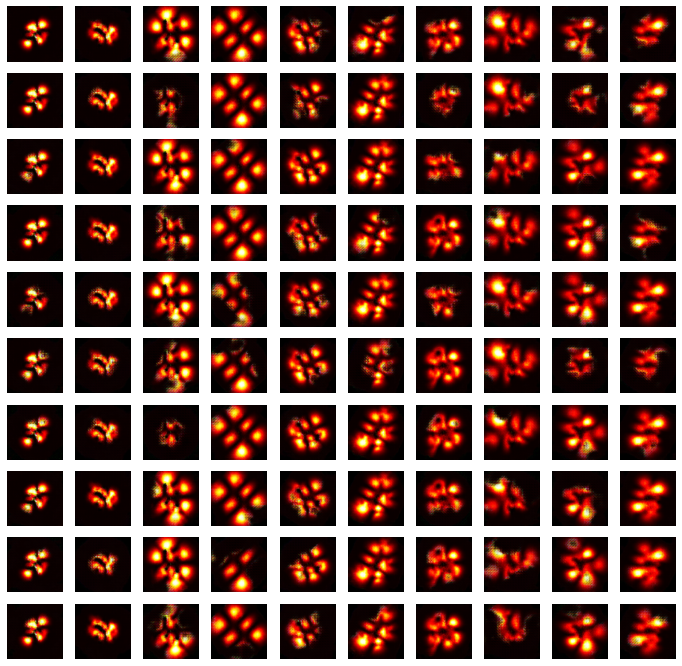

In [18]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.models import load_model
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=21):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

# create and save a plot of generated images
def show_plot(examples, n):
    # plot images
    pyplot.figure(figsize=(12,12))
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i])
    pyplot.show()

# load model
model = load_model(os.path.join(SAVE_RESULT, 'cgan_generator.h5'))
# generate images
latent_points, labels = generate_latent_points(latent_dim, 100)
# specify labels
labels = asarray([x for _ in range(10) for x in range(10)])
#labels = ones((100)) * 0 # generate one thing
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
show_plot(X, 10)